## Define wave families from wave partitions 

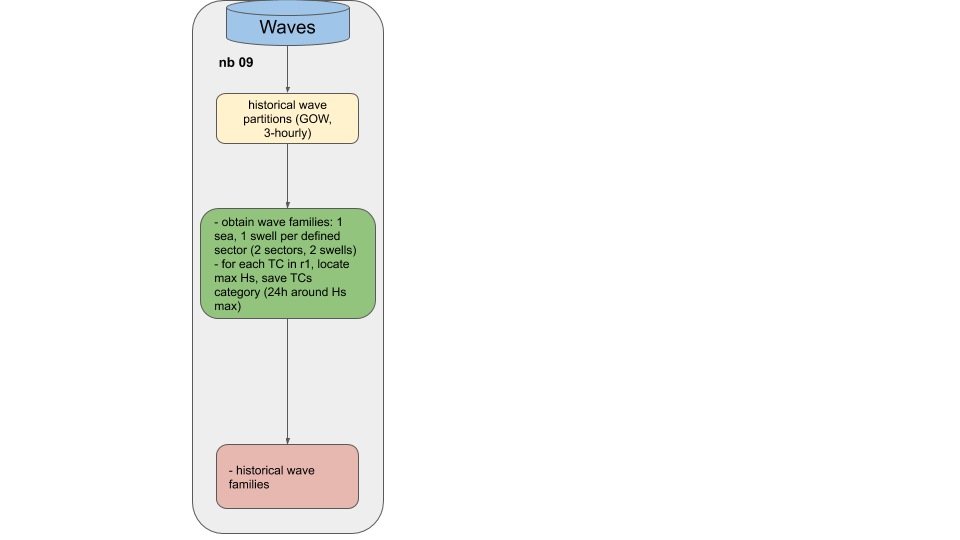

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op
from datetime import datetime

# pip
import numpy as np
import xarray as xr

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.waves import GetDistribution



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'
db = Database(p_data)

# set site
db.SetSite('GUAM')


In [3]:
# --------------------------------------
# load data and set parameters

WVS_pts = db.Load_WAVES_partitions()  # waves partitions data
_, TCs_r1_params = db.Load_TCs_r1_hist()   # TCs historical parameters inside big radius
_, TCs_r2_params = db.Load_TCs_r2_hist()   # TCs historical parameters inside small radius

# wave families sectors
fams_sectors = [(200, 45), (45, 145)]

# date limits for TCs removal from waves data, and TC time window (hours)
tc_rm_date1 = '1979-01-01'
tc_rm_date2 = '2015-12-31'
tc_time_window = 12



## Calculate Historical Waves Families

In [4]:
# --------------------------------------
# Calculate wave families from waves partitions data and waves sectors

WVS = GetDistribution(WVS_pts, fams_sectors)
print(WVS)


<xarray.Dataset>
Dimensions:      (time: 111040)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-01 ... 2016-12-31T21:00:00
Data variables:
    Hs           (time) float64 2.079 2.134 2.085 2.081 ... 2.091 2.032 1.932
    Tp           (time) float64 9.356 9.379 9.433 9.499 ... 9.404 9.335 9.435
    Dir          (time) float64 45.75 50.49 49.68 49.8 ... 40.99 40.44 37.23
    sea_Hs       (time) float64 0.1441 0.19 0.168 ... 0.1403 0.1241 0.1128
    sea_Tp       (time) float64 3.213 2.962 4.8 4.335 ... 3.671 3.346 3.512
    sea_Dir      (time) float64 144.0 144.9 145.1 143.1 ... 151.2 150.8 153.7
    swell_1_Hs   (time) float64 1.716 1.368 1.278 1.244 ... 1.4 1.4 1.424 1.418
    swell_1_Tp   (time) float64 8.925 8.998 8.823 9.333 ... 9.433 9.383 9.521
    swell_1_Dir  (time) float64 27.24 7.344 5.271 6.874 ... 359.3 2.362 3.197
    swell_2_Hs   (time) float64 1.161 1.626 1.636 1.656 ... 1.546 1.443 1.306
    swell_2_Tp   (time) float64 6.972 5.916 6.428 6.174 ... 6.5 6.428 6.


## TCs: Waves  Selection 

In [5]:
# --------------------------------------
# Locate TCs and set category alongside WAVES data  

# remove TCs before 1979 and after 2015 (r1)
dds = TCs_r1_params.dmin_date.values[:]
ix = np.where((dds >= np.datetime64(tc_rm_date1)) & (dds <= np.datetime64(tc_rm_date2)))[0]
TCs_r1_params = TCs_r1_params.isel(storm=ix)

# select storms inside big circle 
storms_sel = TCs_r1_params.storm.values[:]

# add TCs category alongside WAVES data
WVS['TC_category'] = (('time',), np.empty(len(WVS.time))*np.nan)

for s in storms_sel:

    # waves at storm dates
    ss = TCs_r1_params.sel(storm=s)     
    wvs_s = WVS.sel(time = slice(ss.dmin_date, ss.last_date))
    
    # get hs_max date 
    t_hs_max = wvs_s.where(wvs_s.Hs ==  wvs_s.Hs.max(), drop=True).time.values[:][0]
        
    # hs_max time window 
    w1 = t_hs_max - np.timedelta64(tc_time_window,'h')
    w2 = t_hs_max + np.timedelta64(tc_time_window,'h')
    
    # set category alongside WAVES data
    ixs = np.where((WVS.time >= w1) & (WVS.time <= w2))[0]
    WVS['TC_category'][ixs] = ss.category

print(WVS)
    
# Store historical WAVES data
db.Save_WAVES_hist(WVS)


<xarray.Dataset>
Dimensions:      (time: 111040)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-01 ... 2016-12-31T21:00:00
Data variables:
    Hs           (time) float64 2.079 2.134 2.085 2.081 ... 2.091 2.032 1.932
    Tp           (time) float64 9.356 9.379 9.433 9.499 ... 9.404 9.335 9.435
    Dir          (time) float64 45.75 50.49 49.68 49.8 ... 40.99 40.44 37.23
    sea_Hs       (time) float64 0.1441 0.19 0.168 ... 0.1403 0.1241 0.1128
    sea_Tp       (time) float64 3.213 2.962 4.8 4.335 ... 3.671 3.346 3.512
    sea_Dir      (time) float64 144.0 144.9 145.1 143.1 ... 151.2 150.8 153.7
    swell_1_Hs   (time) float64 1.716 1.368 1.278 1.244 ... 1.4 1.4 1.424 1.418
    swell_1_Tp   (time) float64 8.925 8.998 8.823 9.333 ... 9.433 9.383 9.521
    swell_1_Dir  (time) float64 27.24 7.344 5.271 6.874 ... 359.3 2.362 3.197
    swell_2_Hs   (time) float64 1.161 1.626 1.636 1.656 ... 1.546 1.443 1.306
    swell_2_Tp   (time) float64 6.972 5.916 6.428 6.174 ... 6.5 6.428 6.